<a href="https://colab.research.google.com/github/nbekzat/RetinaMNIST_classification/blob/main/supervised_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RetinaMnist+ Classification

Supervised Classification on ResNet18

In [1]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.0 MB/s eta 0:00:00


In [33]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import  models, transforms
import os
from sklearn.metrics import accuracy_score, roc_auc_score

from medmnist import INFO, Evaluator, RetinaMNIST

## We work on RetinaMNist+ dataset with size 224x224

In [3]:
dataset_path = "./dataset"
checkpoint_path = "./checkpoint"
os.makedirs(dataset_path, exist_ok=True)
os.makedirs(checkpoint_path, exist_ok=True)

In [28]:
# CONFIG
batch_size = 128
epochs = 100 #100
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

download_flag = True # download dataset
#dataset_path = "/Users/bekzatnurlanbekova/Documents/DS_C6004/_FIT5126_research/coding/dataset/medmnist/"

# RetinaMnist+ is RGB, we need to use ImageNet normalization
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),       # Eyes can be flipped
    transforms.RandomRotation(degrees=10),         # Slight rotation OK
    transforms.ColorJitter(brightness=0.1,         # Mild color variation
                          contrast=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
])

# Validation/Test: NO augmentation (just normalize)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# LOAD DATA
train_set = RetinaMNIST(split="train", download=download_flag,
                        transform=data_transform, size = 224, root=dataset_path)
test_set = RetinaMNIST(split="test", download=download_flag,
                        transform=test_transform, size = 224, root=dataset_path)
validation_set = RetinaMNIST(split="val", download=download_flag,
                        transform=test_transform, size = 224, root=dataset_path)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

dataset_info = train_set.info
n_classes = len(dataset_info["label"])


5
Dataset RetinaMNIST of size 224 (retinamnist_224)
    Number of datapoints: 1080
    Root location: ./dataset
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0


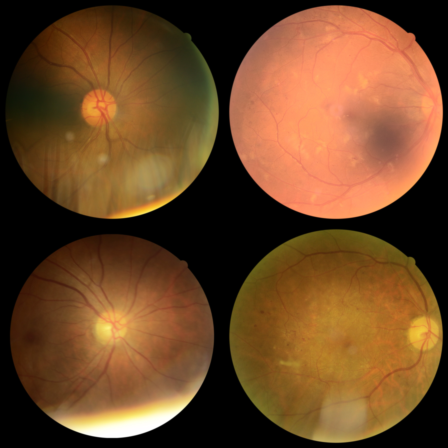

In [29]:
print(n_classes)
print(train_set)
test_set.montage(2)

(array([486.,   0., 128.,   0.,   0., 206.,   0., 194.,   0.,  66.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

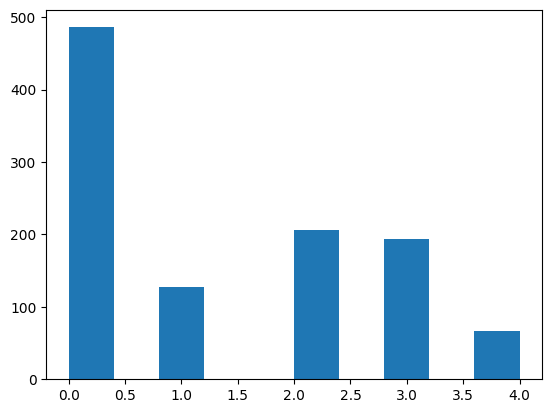

In [21]:
import matplotlib.pyplot as plt
# check for class balance
plt.hist(train_set.labels.squeeze())

We see unbalanced classes distribution.

 ## Train classifier model

 We are using ResNet18 with weights pretrained on ImageNet

In [34]:
# resnet18 with pretrained weights
resnet18 = models.resnet18(weights=True)

# change classifier
# retinaMnist is ordinal regression with 5 classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, n_classes)

resnet18 = resnet18.to(device)

# adopt cross entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(),
                      lr=lr, momentum=0.9,
                      weight_decay=1e-5)

# Add min_lr to prevent going to 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.1,
    patience=7,
    min_lr=1e-6
)

In [36]:
def train():
    resnet18.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        # forward and backward
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(train_loader)

def test(data_loader):
    resnet18.eval()

    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_score = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = resnet18(images)
            outputs = torch.softmax(outputs, dim=1)
            y_score.extend(outputs.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score, multi_class='ovr', average='macro')

    return acc, auc

best_acc = 0
best_epoch = 0
#train with early stopping
patience_counter = 0
early_stop_patience = 20

for epoch in range(epochs):
    # train
    train_loss = train()
    val_acc, val_auc = test(validation_loader)

    # save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "best_acc": best_acc,
            "model_state_dict": resnet18.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        }, os.path.join(checkpoint_path, "resnet18_best_model.pth")
        )
        print(f"Saved best model with ACC: {best_acc:.2f}")
        patience_counter = 0
    else:
        patience_counter += 1

    # Stop if no improvement
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}")
        break

    # Learning rate scheduler
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_acc)

    # Check if learning rate changed
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != current_lr:
        print(f'Learning rate reduced: {current_lr:.6f} -> {new_lr:.6f}')

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {train_loss:.4f} "
          f"Val Acc: {val_acc:.2f}%"
          f"Val AUC: {val_auc:.2f}")

print("Training completed")

Saved best model with ACC: 0.62
Epoch [1/100] Loss: 1.0588 Val Acc: 0.62%Val AUC: 0.84
Epoch [2/100] Loss: 0.9540 Val Acc: 0.58%Val AUC: 0.81
Saved best model with ACC: 0.65
Epoch [3/100] Loss: 0.7576 Val Acc: 0.65%Val AUC: 0.82
Epoch [4/100] Loss: 0.5916 Val Acc: 0.58%Val AUC: 0.83
Epoch [5/100] Loss: 0.4513 Val Acc: 0.62%Val AUC: 0.81
Epoch [6/100] Loss: 0.3627 Val Acc: 0.63%Val AUC: 0.87
Epoch [7/100] Loss: 0.2834 Val Acc: 0.61%Val AUC: 0.83
Saved best model with ACC: 0.68
Epoch [8/100] Loss: 0.2634 Val Acc: 0.68%Val AUC: 0.83
Epoch [9/100] Loss: 0.2027 Val Acc: 0.62%Val AUC: 0.83
Epoch [10/100] Loss: 0.1584 Val Acc: 0.57%Val AUC: 0.80
Epoch [11/100] Loss: 0.1415 Val Acc: 0.66%Val AUC: 0.84
Epoch [12/100] Loss: 0.1383 Val Acc: 0.59%Val AUC: 0.84
Epoch [13/100] Loss: 0.1343 Val Acc: 0.62%Val AUC: 0.84
Epoch [14/100] Loss: 0.1140 Val Acc: 0.60%Val AUC: 0.80
Epoch [15/100] Loss: 0.0913 Val Acc: 0.67%Val AUC: 0.86
Learning rate reduced: 0.010000 -> 0.001000
Epoch [16/100] Loss: 0.0654 V

In [37]:
# Evaluate on test set
checkpoint = torch.load(os.path.join(checkpoint_path, 'resnet18_best_model.pth'))
resnet18.load_state_dict(checkpoint['model_state_dict'])
test_acc, test_auc = test(test_loader)
print(f"Test Acc: {test_acc:.2f}%")
print(f"Test AUC: {test_auc:.2f}")

Test Acc: 0.59%
Test AUC: 0.82
